In [79]:
import json
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.path import Path
from matplotlib.collections import LineCollection, PathCollection

def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

def to_int(value):
    # Remove last character if it's 'l' or 'r'
    val = str(value)
    if val[-1] in 'lr':
        return int(val[:-1])
    return int(val)

def visualize_graph(filepath):
    data = load_data(filepath)
    
    # Create the graph
    G = nx.Graph()
    node_colors = {}  
    label_dict = {}  # Dictionary for custom labels

    for node_id, pos in data['nodes'].items():
        rounded_pos = tuple(round(p, 2) for p in pos)  # Round to nearest hundredth
        G.add_node(str(node_id), pos=rounded_pos[:2])
        node_colors[str(node_id)] = 'lightcoral'
        label_dict[node_id] = str(node_id)

    pos_to_node_id = {tuple(G.nodes[node]['pos']): node for node in G.nodes()}
    
    # Define colors for different paths for clarity
    path_colors = ['#ff6666', '#6666ff', '#ffff00', '#ff66ff', '#66ff33', '#ccffb3', '#b300ff', '#33ffff']

    # Establish paths and shifts
    paths = {}
    lace = []
    for index, path_info in enumerate(data['paths']):
        path = path_info['path']
        paths[index] = path
        shifts = path_info['shifts']

    # Plot unit yarns with specified path starts and shifts
    fig1, ax1 = plt.subplots(figsize=(10, 10))
    fig2, ax2 = plt.subplots(figsize=(5, 5))
    for yarn_id, yarn_data in data['unit_yarns'].items():
        path_id = yarn_data[0]
        node_start_index = yarn_data[1]
        path_start_index = yarn_data[2]
        yarn_path = [to_int(item) for item in paths[path_id]]
        
        # Unit repetitions
        unit_repetition = data['unit_repetion'][str(yarn_id)]
        rep1 = unit_repetition[0]
        vector1 = np.array([unit_repetition[1], unit_repetition[2]])  # Extract x and y components
        vector2 = np.array([unit_repetition[4], unit_repetition[5]])
        rep2 = unit_repetition[3]
        
        # Adjust path for starting point within pattern
        adjusted_path = yarn_path[path_start_index:-1] + yarn_path[:path_start_index]
        current_pos = np.array(G.nodes[str(node_start_index)]['pos'], dtype=float)  # Ensure position is float
        cumulative_shift = np.array([0.0, 0.0])  # Initialize cumulative shift as float

        path_save = []
        path_save.append(current_pos)
        for i in range(len(adjusted_path)): # excluding last point of the path since it is cyclic
            node_start = str(adjusted_path[i % len(adjusted_path)])
            node_end = str(adjusted_path[(i + 1) % len(adjusted_path)])
            
            shift_key = f"[{node_start}, {node_end}]"
            current_shift = np.array(data['paths'][path_id]['shifts'].get(shift_key, (0, 0)), dtype=float)
            cumulative_shift += current_shift
            end_pos = np.array(G.nodes[node_end]['pos'], dtype=float) + cumulative_shift
            rounded_pos = tuple(round(p, 2) for p in end_pos)

            if rounded_pos not in pos_to_node_id:
                new_node = str(end_pos)+'_'+str(rounded_pos[0])+'_'+str(rounded_pos[1])
                G.add_node(new_node, pos=tuple(rounded_pos))  # Ensure pos is tuple as your nodes expect
                node_colors[new_node] = 'lightgray'
                label_dict[new_node] = node_end
                pos_to_node_id[rounded_pos] = new_node
            G.add_edge(pos_to_node_id.get(tuple(current_pos)), pos_to_node_id.get(tuple(end_pos)), color=path_colors[int(yarn_id) % len(path_colors)], linewidth=2)

            path_save.append(end_pos)
                    
            # Update current point
            current_pos = end_pos

        for k2 in range(rep2):
            for k1 in range(rep1):
                replicated_path = [(x + k1*vector1[0] + k2*vector2[0], y + k1*vector1[1] + k2*vector2[1]) for x, y in path_save]
                lace.append(replicated_path)
            lace.append(None)  # Append None to separate each path (vector1 should not brake the path, but make it longer, while vector2 translates the whole path)
            
    # Draw the graph
    colors = [node_colors[node] for node in G.nodes()]
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=colors, node_size=400)
    nx.draw_networkx_edges(G, pos, ax=ax1, edge_color=edge_colors, width=10)    
    nx.draw_networkx_labels(G, pos, ax=ax1, labels=label_dict, font_size=10, font_family='sans-serif')

    # Draw pattern
    lines = [np.array(path) for path in lace if path is not None]  # Convert each path to a NumPy array if not already
    line_collection = LineCollection(lines, colors='k', alpha=0.5, linewidths=1)
    ax2.add_collection(line_collection)
            
    # Set grid spacing
    maj_grid_spacing = 4
    min_grid_spacing = 1  
    ax1.set_xticks(np.arange(np.round((min(x for x, _ in pos.values()) - 1)/maj_grid_spacing)*maj_grid_spacing, np.round((max(x for x, _ in pos.values()) + 1)/maj_grid_spacing)*maj_grid_spacing, maj_grid_spacing))
    ax1.set_yticks(np.arange(np.round((min(y for _, y in pos.values()) - 1)/maj_grid_spacing)*maj_grid_spacing, np.round((max(y for _, y in pos.values()) + 1)/maj_grid_spacing)*maj_grid_spacing, maj_grid_spacing))
    ax1.set_xticks(np.arange(min(x for x, _ in pos.values()) - 1, max(x for x, _ in pos.values()) + 1, min_grid_spacing), minor=True)
    ax1.set_yticks(np.arange(min(y for _, y in pos.values()) - 1, max(y for _, y in pos.values()) + 1, min_grid_spacing), minor=True)
    # Enable the grid
    ax1.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
    ax1.grid(True, which='minor', linestyle='--', color='lightgray', linewidth=0.5)
    
    # Set limits and equal aspect ratio to ensure the grid lines are square if desired
    ax1.set_xlim([min(x for x, _ in pos.values()) - 2, max(x for x, _ in pos.values()) + 2])
    ax1.set_ylim([min(y for _, y in pos.values()) - 2, max(y for _, y in pos.values()) + 2])
    ax1.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')
    # Invert y-axis if required by your coordinate preferences
    ax1.invert_yaxis()
    fig1.canvas.draw()
    fig2.canvas.draw()

    # Crop fig2
    crop = data['roi_bounds']
    ax2.set_xlim(crop['x_min'], crop['x_max'])
    ax2.set_ylim(crop['y_min'], crop['y_max'])
    ax2.invert_yaxis()

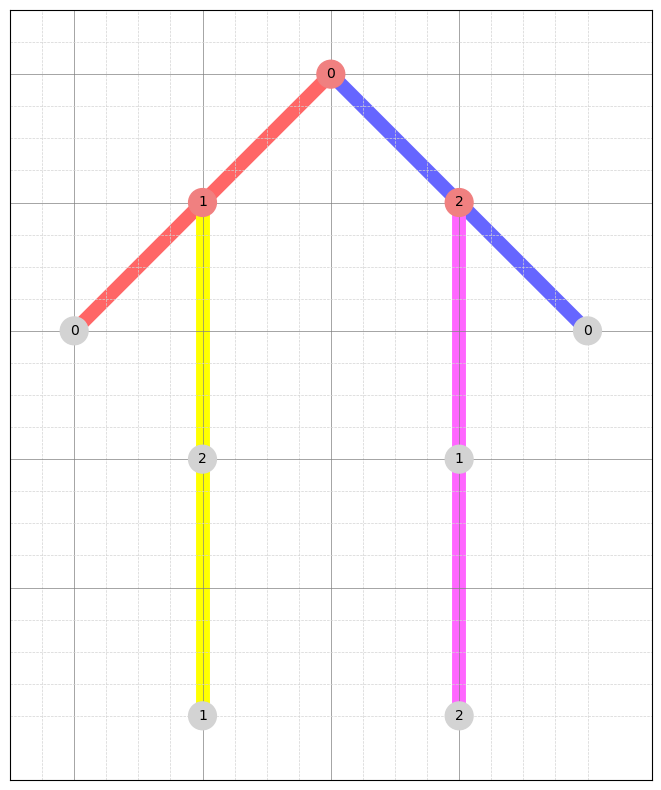

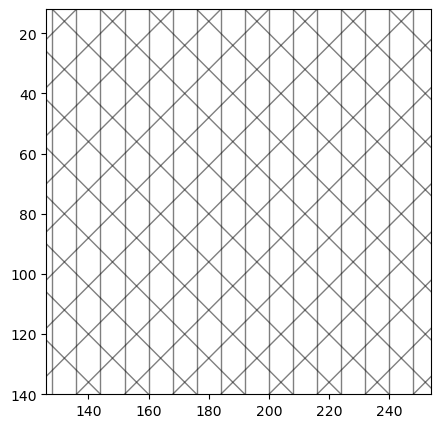

In [80]:
# Pattern 1024
visualize_graph('input/json_patterns/pattern2002.json')